# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Introduction & Proposed Solution

This notebook analyses StarBucks data, which was provided to me.
Three separeate datasets were provided.
1. Offer dataset - Sample of offers (10 offer to be precise)
2. Customer data - Sample of Customer data (17k customers)
3. Transaction data - Sample of sales data (306k transactions)

I've began with understanding data, read features, understand relationships, cleanup the data, reengineering of features for making it easier to put it into algorith.

Few graphs were generated for ease of understanding and to demonstrate to the audience.

Finally, few statistical models were used to fit the data so that the most efficient model can be derived.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import re
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1.1 Cleanup Portfolio DF
Hot encoding of
1. Channels
2. Offer Type

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio['channels1'] = [','.join(map(str, l)) for l in portfolio['channels']]

In [4]:
dummy_channels = portfolio['channels1'].str.get_dummies(sep=",")
portfolio = pd.concat([portfolio, dummy_channels], axis=1)
dummy_offer = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, dummy_offer], axis=1)
portfolio.drop(['channels','channels1','offer_type'], axis =1, inplace = True )
portfolio

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


# 1.2 Cleanup Profile Data
1. Replace age >= 99 to NaN
2. Format date in readable format
3. Convert gender from M/F to 1/0
4. Became_member_on disected into year and month.

In [5]:
profile.loc[profile.age > 98, 'age'] = np.nan
# profile.became_member_on = profile['became_member_on'].astype('datetime64[ns]')
profile.became_member_on = profile.became_member_on.astype('str')
profile.became_member_on = profile['became_member_on'].astype('datetime64[ns]') # , format = "%Y%m%d")

profile = profile.drop(profile[profile['gender'].isnull()].index)

profile = profile.drop(profile[profile['age'].isnull()].index)

profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

# 1.3 Clean Transcript DF
1. Extract offer ID and Amount values from value feature, 2 new features are created.
2. transcript DF will have only those customers who exists in profile (just data validation/ cross checking)
3. conversion of time to days.
4. create offers_df and transaction_df for no-offer and with-offer customers.

In [6]:
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

transcript = unpack(transcript,'value')

In [7]:
transcript.drop(['offer_id','reward'] , axis =1, inplace = True )

In [8]:
transcript.rename(columns={'offer id': 'offer_id'}, inplace=True)
transcript = transcript[transcript.person.isin(profile.id)]

In [9]:
transcript['time'] = transcript['time'] / 24.0

In [10]:
transcript.duplicated().sum()

2856

In [11]:
transcript.drop_duplicates(inplace=True)

In [12]:
transcript.reset_index(drop=True, inplace=True)

In [13]:
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,person,time,amount
11011,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11014,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11016,54890f68699049c2a04d415abc25e717,0.00,13.23
11024,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11025,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
269469,24f56b5e1849462093931b164eb803b5,29.75,22.64
269471,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
269472,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
269473,a00058cf10334a308c68e7631c529907,29.75,3.61


In [14]:
offers_df = transcript[transcript.event!='transaction'].copy()

# hot encode 
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)
offers_df.drop(columns=['event', 'amount'], inplace=True)

In [15]:
offers_df.completed.value_counts()

0    116183
1     29525
Name: completed, dtype: int64

# 2. Data Exploration & Graphs

In [16]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
start_year          0
start_month         0
dtype: int64

In [17]:
year_count = profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
year_count

2017    37.755860
2018    24.751740
2016    20.414781
2015    10.754577
2014     4.472066
2013     1.850976
Name: start_year, dtype: float64

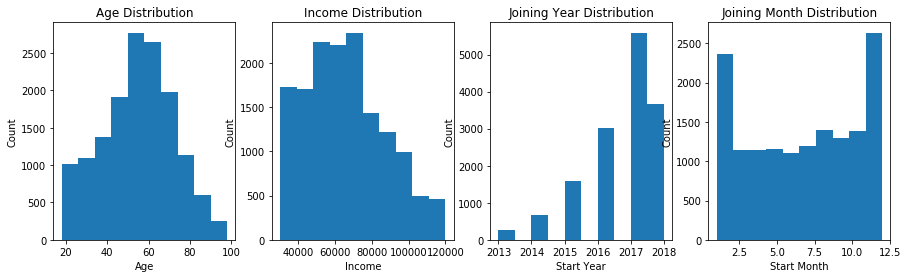

In [18]:
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=4)

plt.sca(ax[0])
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

plt.sca(ax[1])
plt.hist(profile['income'] )
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Distribution');

plt.sca(ax[2])
plt.hist(profile['start_year'])
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.title('Joining Year Distribution');

plt.sca(ax[3])
plt.hist(profile['start_month'])
plt.xlabel('Start Month')
plt.ylabel('Count')
plt.title('Joining Month Distribution');

Text(0.5, 1.0, 'Male Customer Income')

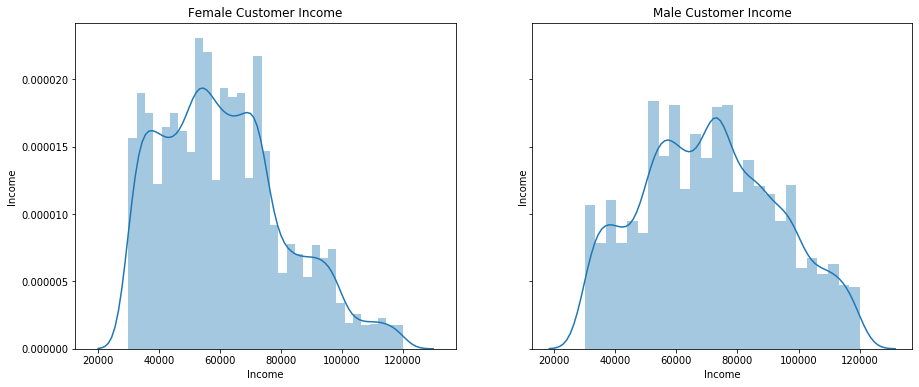

In [19]:
males = profile[profile['gender'] == 0]
females = profile[profile['gender'] == 1]

fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=2, sharex=True, sharey=True)

plt.sca(ax[0])
sns.distplot(females['income'] )
plt.xlabel('Income')
plt.ylabel('Income')
plt.title('Female Customer Income');

plt.sca(ax[1])
sns.distplot(males['income'] )
plt.xlabel('Income')
plt.ylabel('Income')
plt.title('Male Customer Income')


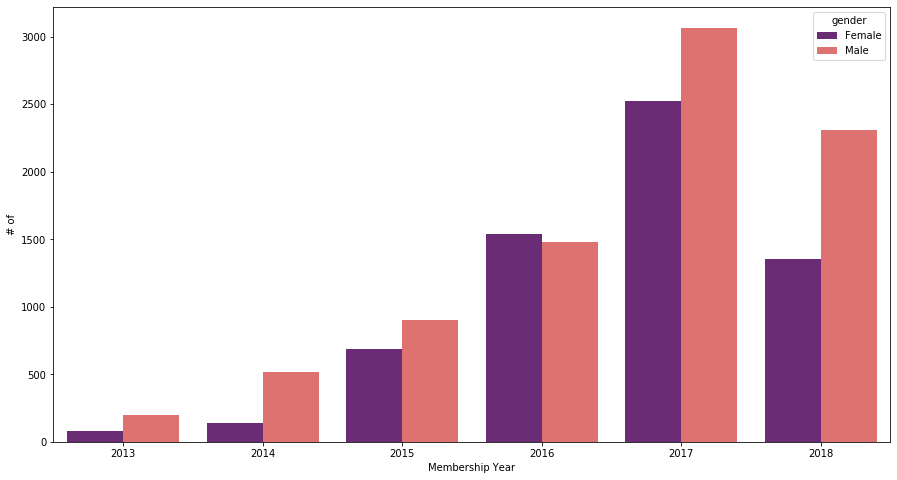

In [20]:
membership_date = profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']
membership_date['gender'] = membership_date['gender'].apply(lambda x: 'Male' if x==True else 'Female' )
#clrs = ["g" if (x == 'Female') else "j" for x in membership_date['gender'] ]

plt.figure(figsize=(15, 8))
sns.barplot(x='start_year', y='count', hue='gender', palette = 'magma', data=membership_date)
plt.xlabel('Membership Year')
plt.ylabel('# of');

# 3. Match and merge datasets 

In [21]:
def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['person'].unique()
    
    
    for ind in range(len(customer_ids)):
        
        cust_id = customer_ids[ind]
        
        customer = profile[profile['id']==cust_id]
        
        cust_offer_data = offers_df[offers_df['person']==cust_id]
        
        cust_transaction_data = transaction_df[transaction_df['person']==cust_id]
        
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        for i in range(offer_received_data.shape[0]):
            
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            offer_row = portfolio.loc[portfolio['id'] == offer_id]
            
            duration_days = offer_row['duration'].values[0]
            
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [22]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

In [23]:
columns_list = ['time', 'offer_id', 'id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
data[columns_list]

,time,offer_id,id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1,0,...,1,1,0,1,2017-05-09,0,100000.0,75.0,2017,5
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0,0,...,1,1,1,0,2017-05-09,0,100000.0,75.0,2017,5
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1,0,...,1,1,1,0,2017-05-09,0,100000.0,75.0,2017,5
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1,0,...,1,1,1,1,2017-05-09,0,100000.0,75.0,2017,5
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0,1,...,1,1,0,1,2018-04-26,1,70000.0,68.0,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66397,24.0,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,34.04,0,10,7,2,0,1,...,1,1,0,1,2017-08-20,1,44000.0,59.0,2017,8
66398,24.0,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,19.92,0,0,3,0,0,0,...,1,1,1,0,2017-08-02,1,64000.0,44.0,2017,8
66399,24.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,28.42,0,5,7,5,1,0,...,1,1,0,1,2018-04-23,1,73000.0,61.0,2018,4
66400,24.0,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,75.84,1,7,7,3,0,1,...,1,1,1,1,2017-12-23,0,86000.0,52.0,2017,12


In [24]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])

data = data[column_ordering]
data = data.drop(columns=['time', 'customer_id', 'id', 'email', 'informational', 'became_member_on'])
data.head()

,offer_id,total_amount,offer_successful,reward,difficulty,duration,mobile,social,web,bogo,discount,gender,age,income,start_year,start_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,5,7,1,0,1,1,0,0,75.0,100000.0,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,0,3,1,1,0,0,0,0,75.0,100000.0,2017,5
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,10,10,7,1,1,0,1,0,0,75.0,100000.0,2017,5
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,5,5,5,1,1,1,1,0,0,75.0,100000.0,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,2,10,7,1,0,1,0,1,1,68.0,70000.0,2018,4


In [25]:
data1 = data.groupby('offer_id')['offer_successful'].size()
data2 = data.offer_successful.eq(1).astype(int).groupby(data.offer_id).sum()
data3 = pd.DataFrame(data2/data1)

# 3.1 Validation and demonstration of data merge

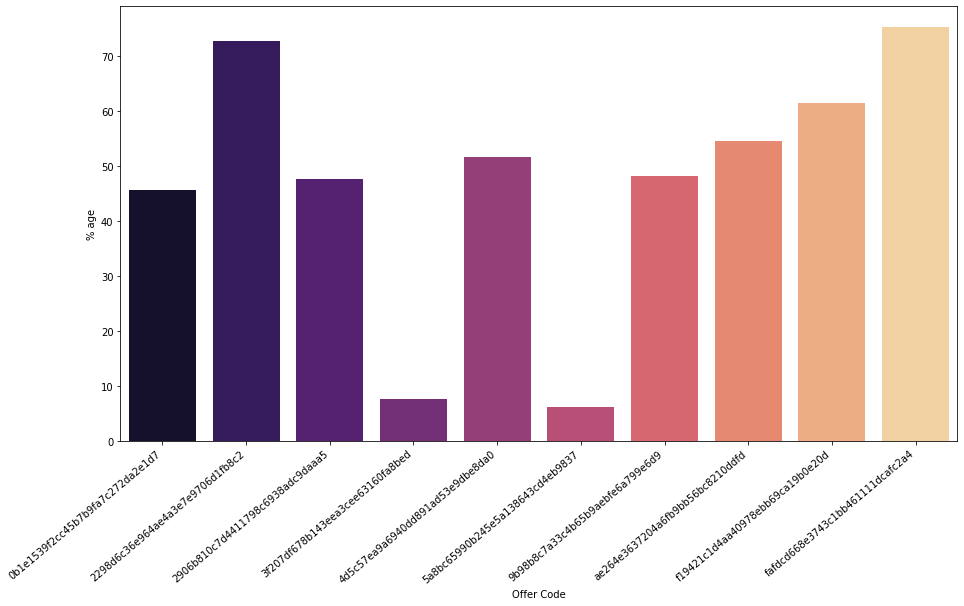

In [26]:
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=data3.index, y=data3.offer_successful * 100 , palette = 'magma', data=data3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Offer Code' )
plt.ylabel('% age');
plt.show()


# 4. Model preparation

In [27]:
features = data.drop(columns=['offer_successful'])

label = data.filter(['offer_successful'])

X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 2]
X_train = X_train[:, 3:].astype('float64')

offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 2]
X_test = X_test[:, 3:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

In [28]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))
print("Naive predictor accuracy: %.4f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.4f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.4732
Naive predictor f1-score: 0.6425


In [29]:
features = data.drop(columns=['offer_successful'])

label = data.filter(['offer_successful'])

# 4.1 Logistic Regression model

In [30]:
scorer = make_scorer(fbeta_score, beta=0.5)

lr_clf = LogisticRegression(random_state=42, solver='liblinear')

grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 1000, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   46.4s finished


In [31]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [32]:
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.699
LogisticRegression model f1-score: 0.697


(0.6991243733998839, 0.6965785077346988)

In [33]:
evaluate_model_performance(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.702
RandomizedSearchCV model f1-score: 0.697


(0.7019727925304955, 0.6966739896796608)

# 4.2 Random Forest Classifier model

In [34]:
rf_clf = RandomForestClassifier(random_state=42)

n_estimators = [10, 50, 100, 150, 200, 250, 300]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  7.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [35]:
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.760
RandomForestClassifier model f1-score: 0.751


(0.7600094662335147, 0.7506649679250765)

In [36]:
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.738
RandomForestClassifier model f1-score: 0.724


(0.7382661512976256, 0.7237176769817718)

# 5 Conclusion

   ## Model accuracy	Score
   Naive predictor accuracy	0.4732 <br> 
   LogisticRegression model accuracy	0.699
   ###### RandomForestClassifier model accuracy	0.762 <br> 
	
   ## Model f1 Score
   Naive predictor f1-score	0.6425<br> 
   LogisticRegression model f1-score	0.697<br> 
   ###### RandomForestClassifier model f1-score	0.753<br> 

From the scores above, it was demonstrated that Random Forest Classifier model had produced better results without overfitting of the data. 

Few points to note:
1. Data set had limited number of features. More features could've produced even better results such as, geographical location, marital status, time of the day etc.

2. While appreciating the amount of data made available for this assignment, a larger dataset would predict better customer behaviour thereby improvement of scope for better offers & tuned offers which results in better customer experience/ satisfaction rating ultimately reaults in profits.